In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data Preparation


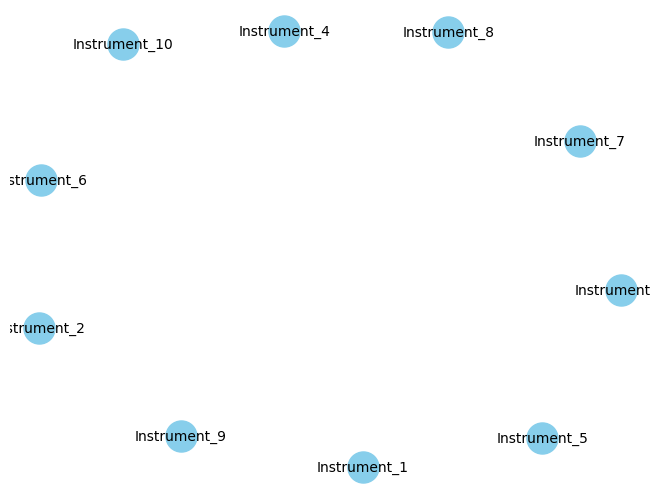

In [16]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Load historical market data and set the date column as the index
data = pd.read_csv('/content/drive/MyDrive/GirlsScriptOpenSource/Hedging-of-Financial-Derivatives/Graph Neural Networks for Network-Based Hedging/synthetic_market_data (1).csv', index_col=0, parse_dates=True)

# Calculate correlation matrix
correlation_matrix = data.corr()

# Create a graph
G = nx.Graph()

# Add nodes (financial instruments)
for column in data.columns:
    G.add_node(column)

# Add edges (relationships based on correlation)
threshold = 0.5  # Define a correlation threshold to create edges
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            G.add_edge(correlation_matrix.columns[i], correlation_matrix.columns[j], weight=correlation_matrix.iloc[i, j])

# Visualize the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', edge_color='gray', font_size=10)
plt.show()


2. Graph Neural Network Model Development

In [17]:
!pip install torch-geometric

In [18]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

# Convert NetworkX graph to PyTorch Geometric data format
data_pg = from_networkx(G)

# Assume the features are the log returns of the prices
log_returns = np.log(data / data.shift(1)).dropna()
data_pg.x = torch.tensor(log_returns.values, dtype=torch.float)

# Generate synthetic target labels (e.g., next day's returns)
data_pg.y = torch.tensor(log_returns.shift(-1).dropna().values.mean(axis=1), dtype=torch.float)

# Define a GNN model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(data_pg.num_node_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.fc = torch.nn.Linear(16, 1)  # Output layer (e.g., predict risk metric)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = torch.mean(x, dim=0)  # Aggregate node features
        x = self.fc(x)
        return x

# Initialize the model, optimizer, and loss function
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()  # Assume we're predicting a continuous variable

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data_pg)
    loss = criterion(out, data_pg.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Train the model
for epoch in range(200):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([250])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.03008471243083477
Epoch 10, Loss: 0.003490667324513197
Epoch 20, Loss: 0.00020153068180661649
Epoch 30, Loss: 0.00016223936108872294
Epoch 40, Loss: 0.0001478358608437702
Epoch 50, Loss: 3.3796044590417296e-05
Epoch 60, Loss: 1.892329783004243e-05
Epoch 70, Loss: 2.2029700630810112e-05
Epoch 80, Loss: 2.0268300431780517e-05
Epoch 90, Loss: 1.862957469711546e-05
Epoch 100, Loss: 1.812954906199593e-05
Epoch 110, Loss: 1.8053289750241674e-05
Epoch 120, Loss: 1.805208194127772e-05
Epoch 130, Loss: 1.805333340598736e-05
Epoch 140, Loss: 1.8052629457088187e-05
Epoch 150, Loss: 1.805178908398375e-05
Epoch 160, Loss: 1.805130705179181e-05
Epoch 170, Loss: 1.805109241104219e-05
Epoch 180, Loss: 1.805100509955082e-05
Epoch 190, Loss: 1.8050975995720364e-05


3. Evaluation and Hedging Strategy Implementation

In [19]:
# Extract features using the trained GNN model
model.eval()
with torch.no_grad():
    features = model(data_pg).view(-1, 1)  # Ensure features have the correct shape

# Implement a simple hedging strategy based on extracted features
# Here, we'll assume a simple threshold-based strategy for illustration
hedge_threshold = 0.1

# Simulated backtesting
def backtest(features, market_data):
    portfolio_value = 100000  # Initial portfolio value
    hedge_positions = []

    for i in range(len(features)):
        signal = features[i].item()  # Example feature signal
        if signal > hedge_threshold:
            hedge_positions.append('Hedge')  # Take a hedge position
        else:
            hedge_positions.append('No Hedge')  # No hedge

    return hedge_positions

# Backtest the strategy
market_data = data_pg.x.numpy()  # Use the log returns as market data
hedge_positions = backtest(features.numpy(), market_data)

# Evaluate the performance
print("Hedge Positions:", hedge_positions)


Hedge Positions: ['No Hedge']


 Plot Hedging Positions Over Time

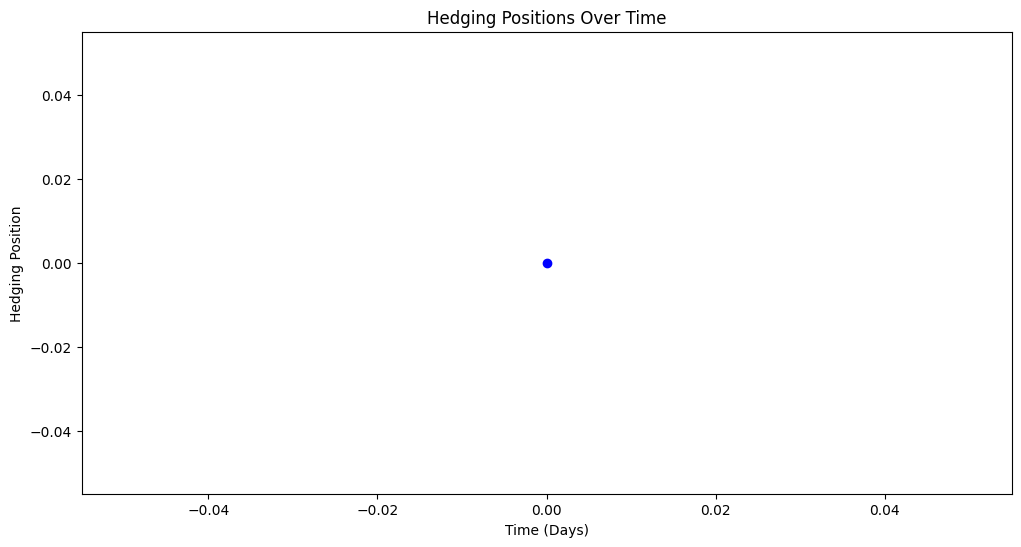

In [20]:
def plot_hedging_positions(hedge_positions):
    hedge_indicator = [1 if pos == 'Hedge' else 0 for pos in hedge_positions]
    plt.figure(figsize=(12, 6))
    plt.plot(hedge_indicator, marker='o', linestyle='-', color='b')
    plt.xlabel('Time (Days)')
    plt.ylabel('Hedging Position')
    plt.title('Hedging Positions Over Time')
    plt.show()

plot_hedging_positions(hedge_positions)
